In [1]:
%matplotlib inline
import utils
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist
from numpy.random import permutation as rpm
from plot import plot_images, plot_dendrogram, plot_confusion_matrix
from utils import resize, sample_index, gen_solution, get_purity, get_nmi
from clustering import kmeans_cluster, hierarchical_cluster

# Loading Signal Data

In [2]:
# load raw signal data
data=np.load('../data/swbd.npy').item()
train_x = data['train']['data']
train_y_raw = data['train']['labels']
train_y = [label.split('_')[0] for label in train_y_raw]
dev_x = data['dev']['data']
dev_y_raw = data['dev']['labels']
dev_y = [label.split('_')[0] for label in dev_y_raw]
test_x = data['test']['data']
test_y_raw = data['test']['labels']
test_y = [label.split('_')[0] for label in test_y_raw]

# used in clustering
signals = train_x+dev_x+test_x # tuple of numpy.ndarray  31961 * [time*39]
labels = train_y+dev_y+test_y  # labels. tuple of strings 31961. e.g. 'abandoned'

print('number of signals: {}'.format(len(signals)))

number of signals: 31961


In [3]:
# count number of words. Change strings to numeric labels
wordSet = set()
for word in labels:
    wordSet.add(word)
print('total number of words is {}'.format(len(wordSet)))

# make a list. let list index be the numeric label of word
wordList = list(wordSet)

# numeric label of signals
numLabels = np.array(list(map(lambda x: wordList.index(x), labels)))

total number of words is 6204


# Loading Embedding Data

In [4]:
# load embedding data
emb_data = np.load('../data/swbd_embeddings2.npy').item()
emb_train_x = emb_data['train']['embs']
emb_train_y_raw = emb_data['train']['labels']
emb_train_y = [label.split('_')[0] for label in train_y_raw]
emb_dev_x = emb_data['dev']['embs']
emb_dev_y_raw = emb_data['dev']['labels']
emb_dev_y = [label.split('_')[0] for label in dev_y_raw]
emb_test_x = emb_data['test']['embs']
emb_test_y_raw = emb_data['test']['labels']
emb_test_y = [label.split('_')[0] for label in test_y_raw]

# labels are the same. Use the embedding matrix in clustering
emb_signals = np.concatenate((emb_train_x,emb_dev_x,emb_test_x), axis = 0) # np.ndarray 31961*512
print('shape of embeddings: {}'.format(emb_signals.shape))

shape of embeddings: (31961, 512)


In [5]:
print(emb_train_x[0])

[ 4.89876755e-02  2.59758364e-02  4.39165719e-03  2.22055987e-02
  4.35344987e-02  1.27043137e-02 -6.81943372e-02 -5.95183372e-02
 -4.47647832e-02  4.79305834e-02 -3.66884051e-03 -6.87419623e-03
  1.62661765e-02  3.71067412e-02 -6.64437562e-02 -2.28014812e-02
 -5.34397624e-02 -3.30656543e-02  3.30852419e-02  1.04370520e-01
 -2.17934381e-02 -3.91339287e-02  5.59174754e-02  8.87487903e-02
 -3.86549309e-02 -2.84964629e-02 -4.55278419e-02  4.27395999e-02
  5.64501509e-02  6.01782613e-02  7.67360034e-05 -3.24948169e-02
  2.20359508e-02  9.33689345e-03  1.23836882e-02 -1.88759714e-02
 -1.14391953e-01 -3.05666216e-02 -3.29553476e-03  4.00276445e-02
 -1.06820427e-02 -1.06726930e-01 -2.00356487e-02  2.52106041e-02
  4.98466678e-02  2.00864803e-02 -2.51766089e-02  2.00877767e-02
 -5.38778715e-02 -7.16257095e-02  2.14780532e-02  1.50978062e-02
 -3.17874132e-03 -6.54633641e-02 -6.35260642e-02 -9.77066979e-02
  2.64971778e-02 -2.33013164e-02 -1.60628255e-03  3.79803479e-02
  1.37570783e-01 -4.94649

# Small raw data and small labels

In [6]:
wordBags = dict()
for word in labels:
    if word in wordBags:
        wordBags[word] += 1
    else:
        wordBags[word] = 1
sorted_by_value = sorted(wordBags.items(), key=lambda kv: -kv[1])
print(sorted_by_value[:20])
print('total number of series: {}'.format(sum([x[1] for x in sorted_by_value[:20]])))

[('because', 340), ('recycling', 315), ('benefits', 259), ('something', 230), ('exactly', 228), ('probably', 225), ('insurance', 196), ('punishment', 190), ('everything', 174), ('company', 149), ('sometimes', 144), ('interesting', 143), ('recycle', 143), ('situation', 141), ('problem', 139), ('anything', 131), ('plastic', 127), ('actually', 125), ('understand', 123), ('vacation', 123)]
total number of series: 3645


In [7]:
# get the small data set
small_index_list = [x[0] for x in sorted_by_value[:20]]
small_raw_signal = []
small_emb_data = []
small_num_labels = []
for i in range(len(labels)):
    if labels[i] in small_index_list:
        small_raw_signal.append(signals[i])
        small_emb_data.append(emb_signals[i,:])
        small_num_labels.append(small_index_list.index(labels[i]))

In [8]:
# concatinate the embeded signal to make a data matrix
small_emb_signal = np.zeros((len(small_emb_data), 512))
for i in range(len(small_emb_data)):
    small_emb_signal[i] = small_emb_data[i]

Small data summary: 
1. small_index_list: array with length 20. Used as a reference for numeric label

    ['because', 'recycling', 'benefits', 'something', 'exactly', 'probably', 
    'insurance', 'punishment', 'everything', 'company', 'sometimes',
    'interesting', 'recycle', 'situation', 'problem', 'anything', 
    'plastic', 'actually', 'understand', 'vacation']
                 
                 
2. small_raw_signal: # list of numpy.ndarray  3645 * [time*39]

3. small_emb_signal: # numpy.ndarray 3645 * 512

4. small_num_labels: # array with length 3645. Numeric Label for each signal.

The signals of embedding coordinate with signals of raw data

In [9]:
# word labels for better presentation
small_labels = [small_index_list[x] for x in small_num_labels]

# Play with signal embeddings

K-means, NMI: 0.454, Purity: 0.472


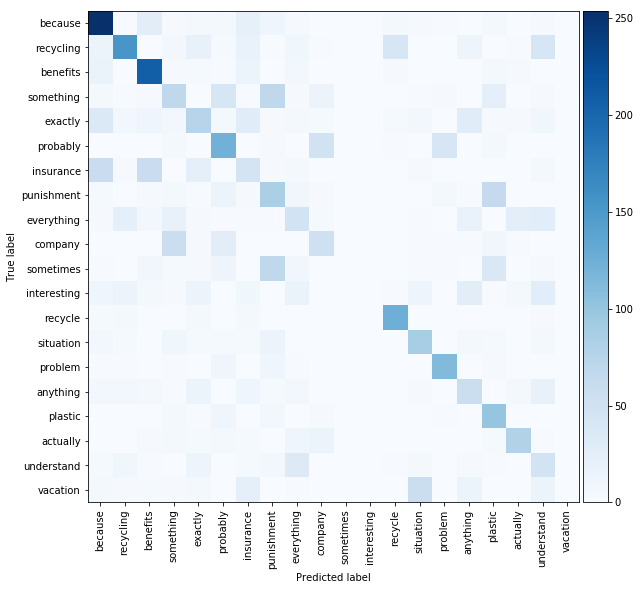

In [10]:
"""
K-means clustering of embedding data
"""
pred = kmeans_cluster(small_emb_signal,len(small_index_list), n_rounds=10, maxrun=500)
_, cm, purity = get_purity(pred, small_num_labels)
nmi = get_nmi(pred, small_num_labels)
plot_confusion_matrix(cm, small_index_list, normalize=False, rotation=90, figsize=(9, 9))
print("K-means, NMI: %.3f, Purity: %.3f" % (nmi, purity))
plt.show()

Ward, NMI: 0.456, Purity: 0.471


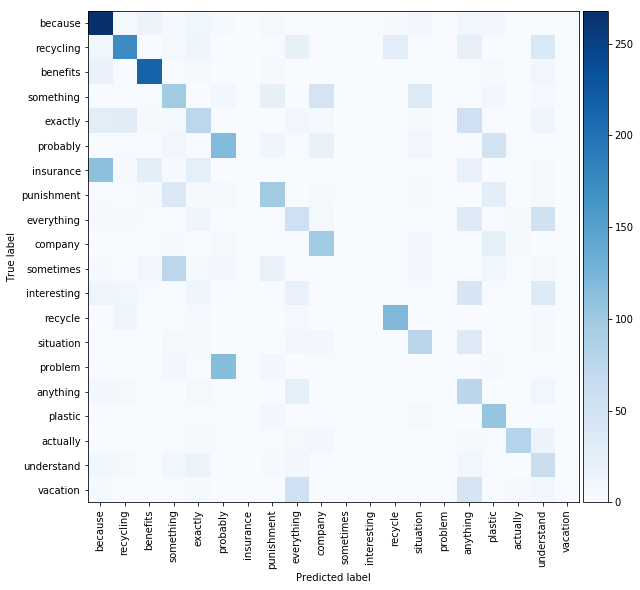

In [11]:
"""
Hierarchical clustering of embedding data
"""
linkage_matrix, pred = hierarchical_cluster(small_emb_signal, n_clusters=len(small_index_list), method='ward', metric='cosine')
_, cm, purity = get_purity(pred, small_num_labels)
nmi = get_nmi(pred, small_num_labels)
plot_confusion_matrix(cm, small_index_list, normalize=False, rotation=90, figsize=(9, 9))
print("Ward, NMI: %.3f, Purity: %.3f" % (nmi, purity))

In [12]:
# test Hierarchical Clustering with other distance measure
methods = ["single" , "complete" , "average" , "weighted" , "centroid" , "median" , "ward"]
for thismethod in methods:
    linkage_matrix, pred = hierarchical_cluster(small_emb_signal, n_clusters=len(small_index_list),method=thismethod, metric='cosine')
    _, cm, purity = get_purity(pred, small_num_labels)
    nmi = get_nmi(pred, small_num_labels)
    print("%s, NMI: %.3f, Purity: %.3f" % (thismethod,nmi, purity))

single, NMI: 0.041, Purity: 0.098
complete, NMI: 0.357, Purity: 0.338
average, NMI: 0.392, Purity: 0.316
weighted, NMI: 0.370, Purity: 0.357
centroid, NMI: 0.048, Purity: 0.099
median, NMI: 0.045, Purity: 0.099
ward, NMI: 0.456, Purity: 0.471


n_neighbors: 10, NMI: 0.472, Purity: 0.433


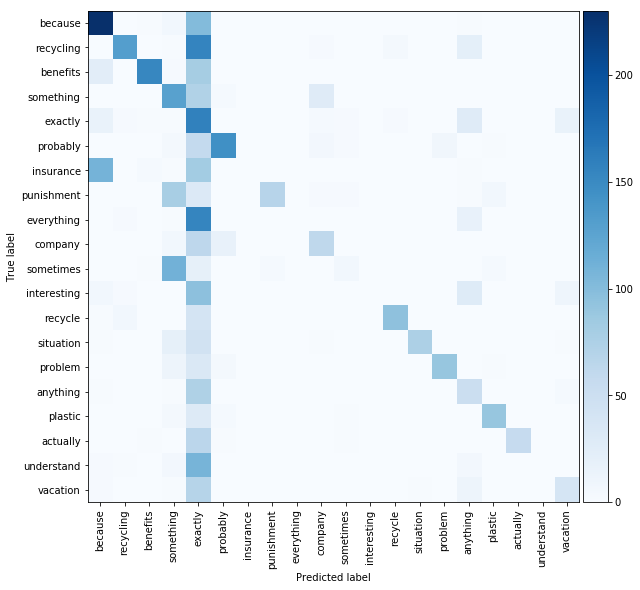

In [13]:
"""
Spectral clustering of embedding data
"""
clustering = SpectralClustering(n_clusters=len(small_index_list),affinity="nearest_neighbors",n_neighbors=10).fit(small_emb_signal)
pred = clustering.labels_
_, cm, purity = get_purity(pred, small_num_labels)
nmi = get_nmi(pred, small_num_labels)
plot_confusion_matrix(cm, small_index_list, normalize=False, rotation=90, figsize=(9, 9))
print("n_neighbors: %s, NMI: %.3f, Purity: %.3f" % (10,nmi, purity))

In [24]:
# try some other number of neighbors
ns_neighbors = [5,10,50]
for n_neighbors in ns_neighbors:
    clustering = SpectralClustering(n_clusters=len(small_index_list),affinity="nearest_neighbors",n_neighbors=n_neighbors).fit(small_emb_signal)
    pred = clustering.labels_
    _, cm, purity = get_purity(pred, small_num_labels)
    nmi = get_nmi(pred, small_num_labels)
    print("n_neighbors: %s, NMI: %.3f, Purity: %.3f" % (n_neighbors,nmi, purity))

/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


n_neighbors: 5, NMI: 0.948, Purity: 0.964
n_neighbors: 10, NMI: 0.952, Purity: 0.970
n_neighbors: 50, NMI: 0.952, Purity: 0.971


In [23]:
# try rbf kernel spectral clustering
clustering = SpectralClustering(n_clusters=len(small_index_list),affinity="rbf").fit(small_emb_signal)
pred = clustering.labels_
_, cm, purity = get_purity(pred, small_num_labels)
nmi = get_nmi(pred, small_num_labels)
print("rbf, NMI: %.3f, Purity: %.3f" % (nmi, purity))

rbf, NMI: 0.407, Purity: 0.347
